#### 資料探勘 作業三

##### 1. 使用 5-fold Cross-Validation 選取能達到最高 CV 正確率的 k。此最佳 k的 CV 正確率為多少？

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

x_train = pd.read_csv('x_train.csv')
print(x_train.shape)
y_train = pd.read_csv('y_train.csv', header=None)
print(y_train.shape)
x_test = pd.read_csv('x_test.csv')
print(x_test.shape)
y_test = pd.read_csv('y_test.csv', header=None)
print(y_test.shape)


(361, 16384)
(361, 1)
(42, 16384)
(42, 1)


In [3]:
x_test = x_test.to_numpy()
x_train = x_train.to_numpy()
# 把它變成一維
y_test = y_test.to_numpy().astype(int).ravel() 
y_train = y_train.to_numpy().astype(int).ravel() 

print("\n--------------new------------\n")
print("x_train:",x_train.shape)
print("y_train:",y_train.shape)
print("x_test:",x_test.shape)
print("y_test:",y_test.shape)



--------------new------------

x_train: (361, 16384)
y_train: (361,)
x_test: (42, 16384)
y_test: (42,)


- 拿一張出來看看他長怎樣

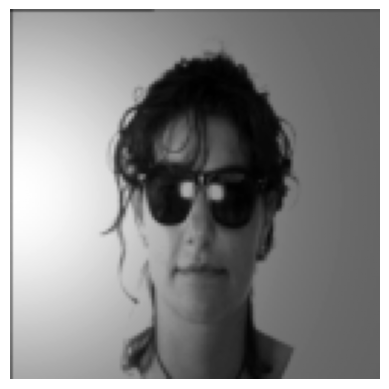

1


In [4]:
# 會發現多一個因為是欄位名裡面是 0 1 2 3 4 5 6 
# 所以要用掉
import matplotlib.pyplot as plt
import numpy as np
image = x_train[100,:].reshape(128,128)
plt.imshow(image , cmap='gray')
plt.axis('off')
plt.show()
print(y_train[100])


- 先試試看k=3的

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd
import numpy as np



# ===== Model =====
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train, y_train)

# ===== Predict =====
y_pred = knn.predict(x_test)

# ===== Evaluate =====
# print(confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.5714285714285714


<hr>

- 這邊應該會是一樣的因為直接用train的資料來看

In [6]:
x = x_train[10].reshape(1, -1)
y_pred = knn.predict(x)
print(y_pred)
print(y_train[10])

[4]
4


- 但是假如用test就不一定了

In [8]:
x = x_test[3].reshape(1, -1)
y_pred = knn.predict(x)
print(y_pred)
print(y_test[3])

[12]
11


- 接下來使用5-fold Cross-Validation

In [9]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler #標準化
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler #除以255

k_values = list(range(1, 21, 2))

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

mean_accuracies = []

for k in k_values:
    pipe = Pipeline([
        ("knn", KNeighborsClassifier(n_neighbors=k))
    ])

    scores = cross_val_score(
        pipe,
        x_train,
        y_train,
        cv=cv,
        scoring="accuracy"
    )

    mean_accuracies.append(scores.mean())
    print(f"k={k:2d}, Accuracy={scores.mean():.3f}")

best_k = k_values[np.argmax(mean_accuracies)]
print("Best k =", best_k)


k= 1, Accuracy=0.906
k= 3, Accuracy=0.806
k= 5, Accuracy=0.734
k= 7, Accuracy=0.704
k= 9, Accuracy=0.651
k=11, Accuracy=0.640
k=13, Accuracy=0.607
k=15, Accuracy=0.587
k=17, Accuracy=0.560
k=19, Accuracy=0.543
Best k = 1


- 他最好的是1，可能是因為在高維度中雜訊比較多

- 因為原本權重一樣的所以我想要試試看 權重根據距離

In [10]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler #標準化
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler #除以255

k_values = list(range(1, 21, 2))

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

mean_accuracies = []

for k in k_values:
    pipe = Pipeline([
        # ("scaler", MinMaxScaler()), 
        ("knn", KNeighborsClassifier(n_neighbors=k , weights='distance'))
    ])

    scores = cross_val_score(
        pipe,
        x_train,
        y_train,
        cv=cv,
        scoring="accuracy"
    )

    mean_accuracies.append(scores.mean())
    print(f"k={k:2d}, Accuracy={scores.mean():.3f}")

best_k = k_values[np.argmax(mean_accuracies)]
print("Best k =", best_k)


k= 1, Accuracy=0.906
k= 3, Accuracy=0.853
k= 5, Accuracy=0.817
k= 7, Accuracy=0.792
k= 9, Accuracy=0.776
k=11, Accuracy=0.745
k=13, Accuracy=0.723
k=15, Accuracy=0.681
k=17, Accuracy=0.676
k=19, Accuracy=0.679
Best k = 1


- 這樣看起來確實有比較好一點

- 想要看看不同seed的效果

In [11]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

k_values = list(range(1, 21, 2))
random_seeds = [0, 1, 2, 42, 123]

rows = []

for k in k_values:
    seed_scores = []

    for seed in random_seeds:
        cv = StratifiedKFold(
            n_splits=5,
            shuffle=True,
            random_state=seed
        )

        pipe = Pipeline([
            ("knn", KNeighborsClassifier(n_neighbors=k))
        ])

        scores = cross_val_score(
            pipe,
            x_train,
            y_train,
            cv=cv,
            scoring="accuracy"
        )

        seed_scores.append(scores.mean())

    rows.append({
        "k": k,
        "mean_accuracy": np.mean(seed_scores),
        "std_accuracy": np.std(seed_scores)
    })

df_results = pd.DataFrame(rows)
df_results


,k,mean_accuracy,std_accuracy
0,1,0.905274,0.009821
1,3,0.800068,0.006181
2,5,0.748524,0.012323
3,7,0.685883,0.015256
4,9,0.635525,0.016555
5,11,0.611697,0.018920
6,13,0.587298,0.012579
7,15,0.566248,0.011148
8,17,0.540228,0.010042
9,19,0.526948,0.014655


In [12]:
rows = []

for k in k_values:
    for seed in random_seeds:
        cv = StratifiedKFold(
            n_splits=5,
            shuffle=True,
            random_state=seed
        )

        pipe = Pipeline([
            ("knn", KNeighborsClassifier(n_neighbors=k))
        ])

        scores = cross_val_score(
            pipe,
            x_train,
            y_train,
            cv=cv,
            scoring="accuracy"
        )

        rows.append({
            "k": k,
            "random_seed": seed,
            "accuracy": scores.mean()
        })

df_long = pd.DataFrame(rows)
df_long


,k,random_seed,accuracy
0,1,0,0.911339
1,1,1,0.886416
2,1,2,0.914117
3,1,42,0.905860
4,1,123,0.908638
5,3,0,0.806126
6,3,1,0.789460
7,3,2,0.797907
8,3,42,0.806126
9,3,123,0.800723


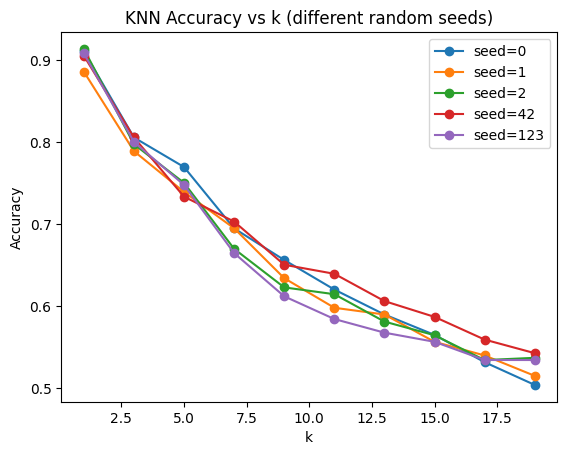

In [13]:
import matplotlib.pyplot as plt

plt.figure()

for seed in sorted(df_long["random_seed"].unique()):
    sub = df_long[df_long["random_seed"] == seed]
    plt.plot(
        sub["k"],
        sub["accuracy"],
        marker="o",
        label=f"seed={seed}"
    )

plt.xlabel("k")
plt.ylabel("Accuracy")
plt.title("KNN Accuracy vs k (different random seeds)")
plt.legend()
plt.show()


- 這邊試試看不同seed是害怕可能剛好到一個local min or max

<hr>
<hr>

##### 使用 1. 中選出的最佳 k，對所有測試影像進行分類。其在測試資料上的判別正確率為多少？

In [14]:

# 1. 使用剛剛選出來的最佳 k (best_k) 重新建立模型 pipeline
final_pipe = Pipeline([
    ("knn", KNeighborsClassifier(n_neighbors=1)) 
])

final_pipe.fit(x_train, y_train)


test_score = final_pipe.score(x_test, y_test)

print("-" * 30)
print(f"最佳 k 值: {best_k}")
print(f"測試集 (Test Set) 準確率: {test_score:.3f}")

------------------------------
最佳 k 值: 1
測試集 (Test Set) 準確率: 0.786


- 其實準確度還可以 要將近8成

<hr>
<hr>

##### Part II 使用 KNN 配合特徵擷取做臉部影像辨識

-  使用 PCA 做特徵擷取

In [ ]:
import numpy as np
from sklearn.decomposition import PCA




pca = PCA(n_components=0.95) 


x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

#這邊是我不太確定分別對他做pca會不會投到不同的空間中
mu = pca.mean_          # shape: (original_dim,)
W = pca.components_.T  # shape: (original_dim, pca_dim)
x_test_pca_manual = (x_test - mu) @ W
x_test_pca_sklearn = pca.transform(x_test)
print(np.allclose(x_test_pca_manual, x_test_pca_sklearn))
print(np.max(np.abs(x_test_pca_manual - x_test_pca_sklearn)))

x_test_pca = x_test_pca_manual
print("原始維度:", x_train.shape[1])
print("降維後維度:", x_train_pca.shape[1])
print("總共解釋的變異量:", np.sum(pca.explained_variance_ratio_))

True
4.729372449219227e-11
原始維度: 16384
降維後維度: 44
總共解釋的變異量: 0.9511085998164756


- 拿一張出來前後對比

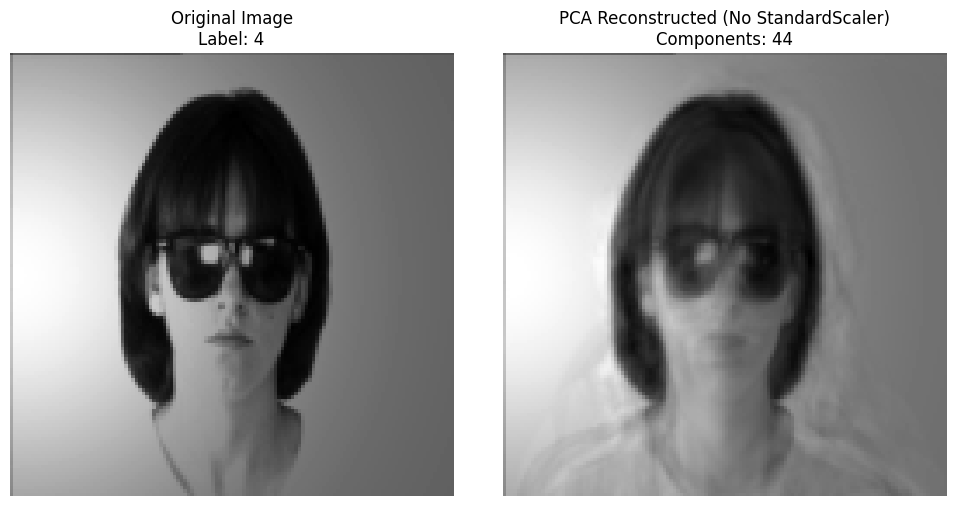

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# ===== 1. 直接用原始影像資料做 PCA =====
pca = PCA(n_components=0.95)
x_train_pca = pca.fit_transform(x_train)

# ===== 2. PCA 反投影回原空間 =====
x_reconstructed = pca.inverse_transform(x_train_pca)

# ===== 3. 顯示原圖 vs PCA 重建 =====
idx = 10

plt.figure(figsize=(10, 5))

# 原圖
plt.subplot(1, 2, 1)
original_img = x_train[idx].reshape(128, 128)
plt.imshow(original_img, cmap="gray")
plt.title(f"Original Image\nLabel: {y_train[idx]}")
plt.axis("off")

# PCA 重建圖
plt.subplot(1, 2, 2)
reconstructed_img = x_reconstructed[idx].reshape(128, 128)
plt.imshow(reconstructed_img, cmap="gray")
plt.title(f"PCA Reconstructed (No StandardScaler)\nComponents: {pca.n_components_}")
plt.axis("off")

plt.tight_layout()
plt.show()


In [17]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

k_values = list(range(1, 21, 2))
mean_accuracies = []

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

for k in k_values:
    pipe = Pipeline([
        ("knn", KNeighborsClassifier(n_neighbors=k))
    ])

    scores = cross_val_score(
        pipe,
        x_train_pca, # 使用 PCA 後的資料
        y_train,
        cv=cv,
        scoring="accuracy"
    )

    mean_accuracies.append(scores.mean())
    print(f"k={k:2d}, Accuracy={scores.mean():.3f}")

best_k = k_values[np.argmax(mean_accuracies)]
print("Best k =", best_k)


k= 1, Accuracy=0.911
k= 3, Accuracy=0.820
k= 5, Accuracy=0.764
k= 7, Accuracy=0.701
k= 9, Accuracy=0.668
k=11, Accuracy=0.643
k=13, Accuracy=0.626
k=15, Accuracy=0.609
k=17, Accuracy=0.557
k=19, Accuracy=0.551
Best k = 1


- ＰＣＡ後正確程度

In [18]:
# 1. 建立最終的 Pipeline 模型 (使用最佳 k)
final_pipe = Pipeline([ 
    ("knn", KNeighborsClassifier(
        n_neighbors=1,
    ))
])

# 2. 使用「所有」訓練資料進行擬合 (Fit)
final_pipe.fit(x_train_pca, y_train)

# 3. 對測試資料 (Test Data) 進行預測並計算準確率
y_pred = final_pipe.predict(x_test_pca)
test_accuracy = accuracy_score(y_test, y_pred)

print("-" * 30)
print(f"測試集 (Test Set) 辨識正確率: {test_accuracy}")

------------------------------
測試集 (Test Set) 辨識正確率: 0.7619047619047619


- 其實準確度也還可以但是比原始還差

<hr>
<hr>

- 這邊試試看LDA

In [19]:
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


lda = LinearDiscriminantAnalysis()
# 直接套用lda
x_train_lda = lda.fit_transform(x_train, y_train)# 這邊已經算出線性組合
x_test_lda = lda.transform(x_test)#會套用這邊的

print("原始維度:", x_train.shape[1])
print("LDA 後維度:", x_train_lda.shape[1])

best_k = 1
# 做knn 
final_pipe = Pipeline([
    ("knn", KNeighborsClassifier(
        n_neighbors=best_k, # 這邊k = 1 用cross validation得出的
    ))
])


final_pipe.fit(x_train_lda, y_train)


y_pred = final_pipe.predict(x_test_lda)
test_accuracy = accuracy_score(y_test, y_pred)

print(f"測試集辨識正確率: {test_accuracy}")


原始維度: 16384
LDA 後維度: 20
測試集辨識正確率: 0.6190476190476191


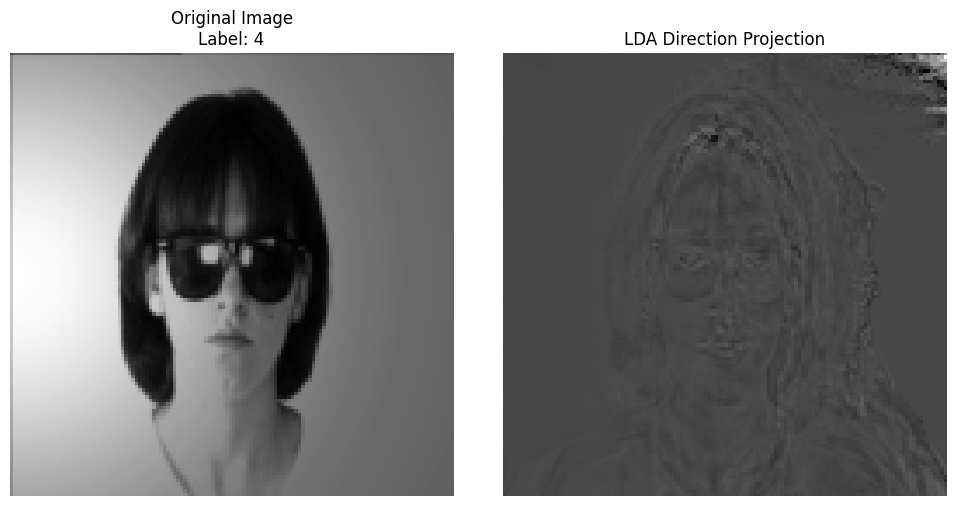

In [21]:
idx = 10
original_img = x_train[idx].reshape(128, 128)

# ===== LDA 投影矩陣（原始空間）=====
# scalings_: (原始維度, n_classes - 1)
W = lda.scalings_[:, :x_train_lda.shape[1]]

# 該樣本在 LDA 空間中的座標
z = x_train_lda[idx]  # shape: (lda_dim,)

# ===== 投影回原始像素空間（近似）=====
x_lda_back = z @ W.T  # shape: (原始維度,)

# ===== 視覺化 =====
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(original_img, cmap="gray")
plt.title(f"Original Image\nLabel: {y_train[idx]}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(x_lda_back.reshape(128, 128), cmap="gray")
plt.title("LDA Direction Projection")
plt.axis("off")

plt.tight_layout()
plt.show()


- 但其實我不太確定是不是這樣畫的，這我問gpt的

<hr>

- 這邊是看看他在2維度會怎麼表現

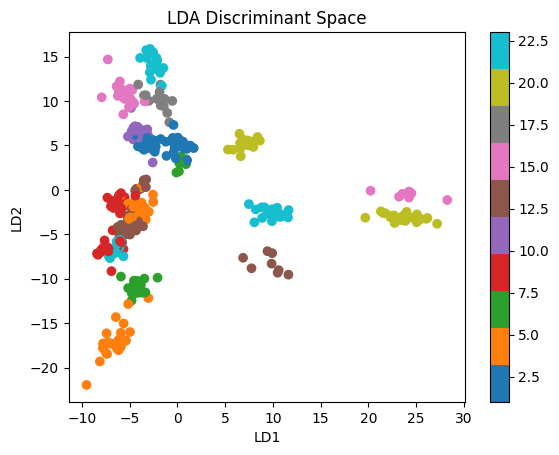

In [22]:
plt.scatter(x_train_lda[:, 0], x_train_lda[:, 1], c=y_train, cmap="tab10")
plt.xlabel("LD1")
plt.ylabel("LD2")
plt.title("LDA Discriminant Space")
plt.colorbar()
plt.show()


In [23]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(solver="svd")
x_train_lda = lda.fit_transform(x_train, y_train)
print("LDA explained variance ratio:")
for i, r in enumerate(lda.explained_variance_ratio_):
    print(f"LD{i+1}: {r:.4f}")


LDA explained variance ratio:
LD1: 0.1510
LD2: 0.1198
LD3: 0.0993
LD4: 0.0816
LD5: 0.0700
LD6: 0.0627
LD7: 0.0520
LD8: 0.0475
LD9: 0.0445
LD10: 0.0418
LD11: 0.0352
LD12: 0.0324
LD13: 0.0302
LD14: 0.0278
LD15: 0.0224
LD16: 0.0213
LD17: 0.0192
LD18: 0.0172
LD19: 0.0127
LD20: 0.0116


- 這二十維度可以看看各個維度的判別能力，但這個不等於解釋能力（假如理解沒錯的話）

- 一樣來做k fold cross validation

In [24]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

k_values = list(range(1, 21, 2))
mean_accuracies = []

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=20
)

for k in k_values:
    pipe = Pipeline([
        ("knn", KNeighborsClassifier(
            n_neighbors=k
        ))
    ])

    scores = cross_val_score(
        pipe,
        x_train_lda, # 使用 LDA 後的資料
        y_train,
        cv=cv,
        scoring="accuracy"
    )

    mean_accuracies.append(scores.mean())
    print(f"k={k:2d}, Accuracy={scores.mean()}")

best_k = k_values[np.argmax(mean_accuracies)]
print("Best k =", best_k)


k= 1, Accuracy=1.0
k= 3, Accuracy=1.0
k= 5, Accuracy=1.0
k= 7, Accuracy=1.0
k= 9, Accuracy=1.0
k=11, Accuracy=1.0
k=13, Accuracy=0.9834094368340944
k=15, Accuracy=0.9722983257229834
k=17, Accuracy=0.9667427701674278
k=19, Accuracy=0.9556316590563165
Best k = 1


In [25]:
# 做knn 這邊k = 1
final_pipe = Pipeline([
    ("knn", KNeighborsClassifier(
        n_neighbors=best_k,
    ))
])


final_pipe.fit(x_train_lda, y_train)


y_pred = final_pipe.predict(x_test_lda)
test_accuracy = accuracy_score(y_test, y_pred)

print("-" * 30)
print(f"測試集 (Test Set) 辨識正確率: {test_accuracy}")



------------------------------
測試集 (Test Set) 辨識正確率: 0.6190476190476191


- 這上面感覺應該試overfitting 了
- 因為train很準但是測試及不準

<hr>
<hr>

- 但是其實應該要先做pca再做lda

In [27]:
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# import pca
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95) 
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)


lda = LinearDiscriminantAnalysis()
# 直接套用lda
x_train_lda = lda.fit_transform(x_train_pca, y_train)# 這邊已經算出線性組合
x_test_lda = lda.transform(x_test_pca)#會套用這邊的

print("原始維度:", x_train.shape[1])
print("LDA 後維度:", x_train_lda.shape[1])


原始維度: 16384
LDA 後維度: 20


In [29]:
print("LDA explained variance ratio:")
for i, r in enumerate(lda.explained_variance_ratio_):
    print(f"LD{i+1}: {r:.4f}")


LDA explained variance ratio:
LD1: 0.1989
LD2: 0.1392
LD3: 0.1073
LD4: 0.0906
LD5: 0.0684
LD6: 0.0619
LD7: 0.0541
LD8: 0.0491
LD9: 0.0335
LD10: 0.0318
LD11: 0.0281
LD12: 0.0256
LD13: 0.0239
LD14: 0.0202
LD15: 0.0184
LD16: 0.0140
LD17: 0.0117
LD18: 0.0090
LD19: 0.0087
LD20: 0.0057


In [30]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

k_values = list(range(1, 21, 2))
mean_accuracies = []

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=20
)

for k in k_values:
    pipe = Pipeline([
        ("knn", KNeighborsClassifier(
            n_neighbors=k
        ))
    ])

    scores = cross_val_score(
        pipe,
        x_train_lda, # 使用 LDA 後的資料
        y_train,
        cv=cv,
        scoring="accuracy"
    )

    mean_accuracies.append(scores.mean())
    print(f"k={k:2d}, Accuracy={scores.mean()}")

best_k = k_values[np.argmax(mean_accuracies)]
print("Best k =", best_k)


k= 1, Accuracy=1.0
k= 3, Accuracy=0.9944444444444445
k= 5, Accuracy=0.9944444444444445
k= 7, Accuracy=0.9916666666666668
k= 9, Accuracy=0.9916666666666668
k=11, Accuracy=0.9916666666666668
k=13, Accuracy=0.969482496194825
k=15, Accuracy=0.950076103500761
k=17, Accuracy=0.950076103500761
k=19, Accuracy=0.9417427701674278
Best k = 1


In [31]:
# 做knn 這邊k = 1
final_pipe = Pipeline([
    ("knn", KNeighborsClassifier(
        n_neighbors=best_k,
    ))
])


final_pipe.fit(x_train_lda, y_train)


y_pred = final_pipe.predict(x_test_lda)
test_accuracy = accuracy_score(y_test, y_pred)

print("-" * 30)
print(f"測試集 (Test Set) 辨識正確率: {test_accuracy}")



------------------------------
測試集 (Test Set) 辨識正確率: 1.0


- 可以發現準確度很高 這樣確實要先做ｐｃａ會是比較好的

<hr>

##### 比較 Part I. 中未使用特徵擷取的結果，與此處使用 PCA 與 LDA 之後的表現。三種方法中哪一種表現較佳？你認為原因是什麼？

###### 結論：
- 其實在原始資料下準確度反而是最高的跟單純用lda或是pca都還高
- 反而在pca lda降維度後反而正確度下降了
- 但是其實在我的想像中單純用lda應該效果就會很好，但實際做下來並非如此
- 在單純訓練時lda其實也很不錯，但是在測試的部分不準
- 但是當pca lda 一起用的時候準確度會變很高，不管是訓練還是測試
- 感覺是因為雜訊被排出了
- 但是個人感覺或許有些資料並非如此，譬如剩下5%可能才是可以分別出差別的部分